# Imports

In [44]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
import keras
from IPython.display import FileLink
from keras.models import Sequential
from keras.layers import Dense,Dropout,Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Loading data

In [20]:
def parse_file(file_name, is_propaganda):
    with open(file_name, "r") as file:
        lines = file.readlines()[1:]
        res = pd.DataFrame([line.strip() for line in lines], columns=["text"])
        res["target"] = 1 if is_propaganda else 0
        return res

In [21]:
def combine_datasets(datasets):
    result = datasets[0]
    for dataset in datasets[1:]:
        result = pd.concat([result, dataset], ignore_index=True)
    return result

In [30]:
russian_propaganda = parse_file("/kaggle/input/propaganda-detection-dataset/russian-propaganda.augmented.csv", True)
social_media_data = parse_file("/kaggle/input/propaganda-detection-dataset/non-propaganda.csv", False)
true_news = parse_file("/kaggle/input/ukrainian-news/ukrainian-news.translated.csv", False)
dataset = combine_datasets([russian_propaganda, social_media_data, true_news])
dataset["text"] = dataset["text"].astype(str)
dataset = dataset.dropna()

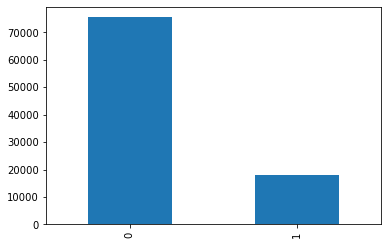

In [32]:
dataset["target"].value_counts().plot(kind='bar')

In [33]:
dataset

,text,target
0,The Holodomor theme is a term that appeared in...,1
1,The US is supporting terrorists in Iran and ai...,1
2,George Soros is behind many political convulsi...,1
3,The Ukrainian secret service manipulated a sou...,1
4,Belgian PM Charles Micheal told the press afte...,1
...,...,...
93594,Hungary wants the EU ban on the domestic sale ...,0
93595,"On Independence Day, we are launching a new fo...",0
93596,As a result of the special operation of the Uk...,0
93597,to help safe education The famous Ukrainian ar...,0


# Training Model

In [34]:
train = dataset.text
target = dataset.target

In [35]:
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=0.2, random_state=42)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (74879,)
Shape of Validation  (18720,)


In [40]:
use_url = "https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2"
embed_layer = hub.KerasLayer(use_url, trainable=False)
model = Sequential()
model.add(Input(shape = [], dtype = tf.string))
model.add(embed_layer)
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['acc'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 256,863,617
Trainable params: 65,793
Non-trainable params: 256,797,824
_________________________________________________________________


In [42]:
history=model.fit(X_train, y_train, batch_size=32, epochs=5, verbose=1, validation_data=(X_val, y_val))

Epoch 1/5
2340/2340 [==============================] - 39s 17ms/step - loss: 0.1600 - acc: 0.9328 - val_loss: 0.1249 - val_acc: 0.9494
Epoch 2/5
2340/2340 [==============================] - 39s 17ms/step - loss: 0.1102 - acc: 0.9548 - val_loss: 0.1040 - val_acc: 0.9587
Epoch 3/5
2340/2340 [==============================] - 39s 17ms/step - loss: 0.0910 - acc: 0.9635 - val_loss: 0.0952 - val_acc: 0.9627
Epoch 4/5
2340/2340 [==============================] - 39s 17ms/step - loss: 0.0772 - acc: 0.9700 - val_loss: 0.0871 - val_acc: 0.9665
Epoch 5/5
2340/2340 [==============================] - 39s 17ms/step - loss: 0.0657 - acc: 0.9753 - val_loss: 0.0827 - val_acc: 0.9679


# Model validation

In [50]:
predictions = np.round(model.predict(X_val).flatten())
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     15150
           1       0.92      0.91      0.92      3570

    accuracy                           0.97     18720
   macro avg       0.95      0.95      0.95     18720
weighted avg       0.97      0.97      0.97     18720



# Inference

In [110]:
sentences = [
    "I like to drink beer",
    "You are bad guy",
    "USA confront Russian and wants to destroy it",
    "Ukraine will lose the war",
    "Ukraine will win the war",
    "Ukraine has won the Kyiv defence",
    "i was in ukraine, it is beautiful",
    "Russian will win the war against NATO",
    "Ukraine will not be in european union",
    'Today i was in dominos and it was good',
    "Russia is a powerful country",
    "Ukraine has nazi regime"
]
predictions = model.predict(sentences).flatten() > 0.5

In [111]:
for sentence, prediction in zip(sentences, predictions):
    print(f"'{sentence}':{prediction}")

'I like to drink beer':False
'You are bad guy':False
'USA confront Russian and wants to destroy it':True
'Ukraine will lose the war':True
'Ukraine will win the war':False
'Ukraine has won the Kyiv defence':False
'i was in ukraine, it is beautiful':False
'Russian will win the war against NATO':True
'Ukraine will not be in european union':True
'Today i was in dominos and it was good':False
'Russia is a powerful country':True
'Ukraine has nazi regime':True


# Save Model

In [ ]:
model.save("propaganda-model.keras")
os.chdir(r'/kaggle/working')
FileLink("propaganda-model.keras")